<a href="https://colab.research.google.com/github/Darth-Hidious/rando6969/blob/main/chemie_versuch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

class TitrationCurve:
    def __init__(self, data):
        self.data = data
        self.df = pd.DataFrame(data, columns=['Volume (ml)', 'pH'])

    def plot_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['Volume (ml)'], self.df['pH'], marker='o', markersize=3, linestyle='-', linewidth=1, color='b', label='Titration Curve')
        plt.title('Titrationskurve von Phosphorsäure')
        plt.xlabel('Volumen von zugegebenem NaOH (ml)')
        plt.ylabel('pH')
        plt.xlim(0, max(self.df['Volume (ml)']) + 0.5)
        plt.ylim(0, max(self.df['pH']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.savefig('titration_curve.png', dpi=300)
        plt.show()

    @staticmethod
    def linear_fit(x, a, b):
        return a * x + b

    def display_table(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=self.df.values, colLabels=self.df.columns, cellLoc='center', loc='center')
        plt.savefig('data_table.png', dpi=300)
        plt.show()

    def save_data(self, filename='titration_data.csv'):
        self.df.to_csv(filename, index=False)


class TitrationSet(TitrationCurve):
    def __init__(self, data):
        super().__init__(data)
        self.tangent_lines = {}

    def add_tangent(self, point, color, length=1.0):
        range_mask = (self.df['Volume (ml)'] > point[0] - 0.5) & (self.df['Volume (ml)'] < point[0] + 0.5)
        x_range = self.df['Volume (ml)'][range_mask]
        y_range = self.df['pH'][range_mask]
        popt, _ = curve_fit(self.linear_fit, x_range, y_range)
        self.tangent_lines[tuple(point)] = (popt, color, length)

    def plot_tangents(self):
        for point, (popt, color, length) in self.tangent_lines.items():
            x_fit = np.linspace(point[0] - length/2, point[0] + length/2, 400)
            plt.plot(x_fit, self.linear_fit(x_fit, *popt), linestyle='--', color=color, linewidth=1, label=f'Tangent at {point}')

    def find_intersections(self):
        def intersection(popt1, popt2):
            a1, b1 = popt1
            a2, b2 = popt2
            x_intersect = (b2 - b1) / (a1 - a2)
            y_intersect = a1 * x_intersect + b1
            return x_intersect, y_intersect

        intersections = {}
        points = list(self.tangent_lines.keys())
        for i in range(len(points) - 1):
            for j in range(i + 1, len(points)):
                intersect = intersection(self.tangent_lines[points[i]][0], self.tangent_lines[points[j]][0])
                if 0 <= intersect[0] <= max(self.df['Volume (ml)']):
                    intersections[f'{points[i]}_vs_{points[j]}'] = intersect
        return intersections

    def annotate_intersections(self, intersections, suffix):
        V1, V2, V3, V4 = None, None, None, None
        points = sorted(intersections.values(), key=lambda x: x[0])

        if suffix == '1':
            if len(points) > 0:
                V1 = points[0][0]
                plt.axvline(x=V1, color='k', linestyle='--', linewidth=0.5)
                plt.annotate(f'V1', xy=(V1, 0), xytext=(V1, -0.5), textcoords='offset points', ha='center')
            if len(points) > 1:
                V2 = points[1][0]
                plt.axvline(x=V2, color='k', linestyle='--', linewidth=0.5)
                plt.annotate(f'V2', xy=(V2, 0), xytext=(V2, -0.5), textcoords='offset points', ha='center')
            if V1 is not None and V2 is not None:
                V_mid_1 = (V1 + V2) / 2
                plt.axvline(x=V_mid_1, color='k', linestyle='-', linewidth=0.5)
                plt.annotate(f'ÄP 1', xy=(V_mid_1, 0), xytext=(V_mid_1, 0.5), textcoords='offset points', ha='center')

        if suffix == '2':
            if len(points) > 0:
                V3 = points[0][0]
                plt.axvline(x=V3, color='k', linestyle='--', linewidth=0.5)
                plt.annotate(f'V3', xy=(V3, 0), xytext=(V3, -0.5), textcoords='offset points', ha='center')
            if len(points) > 1:
                V4 = points[1][0]
                plt.axvline(x=V4, color='k', linestyle='--', linewidth=0.5)
                plt.annotate(f'V4', xy=(V4, 0), xytext=(V4, -0.5), textcoords='offset points', ha='center')
            if V3 is not None and V4 is not None:
                V_mid_2 = (V3 + V4) / 2
                plt.axvline(x=V_mid_2, color='k', linestyle='-', linewidth=0.5)
                plt.annotate(f'ÄP 2', xy=(V_mid_2, 0), xytext=(V_mid_2, 0.5), textcoords='offset points', ha='center')

        return V1, V2, V3, V4

    def find_intersection_with_curve(self, x_value):
        df = self.df
        lower_index = df[df['Volume (ml)'] <= x_value].index[-1]
        upper_index = df[df['Volume (ml)'] > x_value].index[0]
        x1, y1 = df.iloc[lower_index]
        x2, y2 = df.iloc[upper_index]
        y_intersect = y1 + (y2 - y1) * (x_value - x1) / (x2 - x1)
        return x_value, y_intersect


class TitrationAnalysis:
    def __init__(self, data):
        self.data = data
        self.set1 = TitrationSet(data)
        self.set2 = TitrationSet(data)

    def plot_with_tangents(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.data[:, 0], self.data[:, 1], marker='o', markersize=3, linestyle='-', linewidth=1, color='b', label='Titration Curve')


        self.set1.plot_tangents()
        intersections_1 = self.set1.find_intersections()
        V1, V2, _, _ = self.set1.annotate_intersections(intersections_1, '1')


        self.set2.plot_tangents()
        intersections_2 = self.set2.find_intersections()
        V3, V4, _, _ = self.set2.annotate_intersections(intersections_2, '2')


        if V1 is not None and V2 is not None:
            V_mid_1 = (V1 + V2) / 2
            x1, y1 = self.set1.find_intersection_with_curve(V_mid_1)
            plt.plot(x1, y1, 'ro')
            plt.annotate(f'({y1:.2f})', xy=(x1, y1), xytext=(x1+0.1, y1+0.5),
                         textcoords='offset points', ha='center', color='black')

        if V3 is not None and V4 is not None:
            V_mid_2 = (V3 + V4) / 2
            x2, y2 = self.set2.find_intersection_with_curve(V_mid_2)
            plt.plot(x2, y2, 'ro')
            plt.annotate(f'{y2:.2f})', xy=(x2-3, y2-3), xytext=(x2+0.1, y2+0.5),
                         textcoords='offset points', ha='center', color='black')

        plt.title('Titrationskurve von Phosphorsäure mit Tangenten')
        plt.xlabel('Volumen von zugegebenem NaOH (ml)')
        plt.ylabel('pH')
        plt.xlim(0, max(self.data[:, 0]) + 0.5)
        plt.ylim(0, max(self.data[:, 1]) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.savefig('titration_curve_with_tangents.png', dpi=300)
        plt.show()


In [2]:
# Datenarray zur Titration von Phosphorsäure, ich habe gemessen
data = np.array([
    [0, 2.89],
    [0.2, 2.85],
    [0.4, 2.89],
    [0.6, 2.95],
    [0.8, 3.02],
    [1, 3.10],
    [1.2, 3.20],
    [1.4, 3.34],
    [1.6, 3.54],
    [1.8, 3.96],
    [1.9, 4.29],
    [2, 5.12],
    [2.05, 5.49],
    [2.1, 5.74],
    [2.15, 5.90],
    [2.25, 6.05],
    [2.3, 6.16],
    [2.5, 6.40],
    [2.7, 6.61],
    [2.9, 6.78],
    [3.1, 6.95],
    [3.3, 7.13],
    [3.5, 7.32],
    [3.75, 7.55],
    [3.8, 7.65],
    [3.85, 7.75],
    [3.95, 7.92],
    [4.0, 8.12],
    [4.05, 8.42],
    [4.15, 8.85],
    [4.25, 9.5],
    [4.35, 9.7],
    [4.40, 9.81],
    [4.45, 9.90],
    [4.55, 10.01],
    [4.60, 10.08],
    [4.70, 10.15],
    [4.75, 10.21],
    [4.82, 10.27],
    [4.90, 10.30],
    [4.96, 10.35],
    [5, 10.39],
    [5.07, 10.42],
    [5.12, 10.46],
    [5.18, 10.49],
    [5.25, 10.51]
])

titration_analysis = TitrationAnalysis(data)


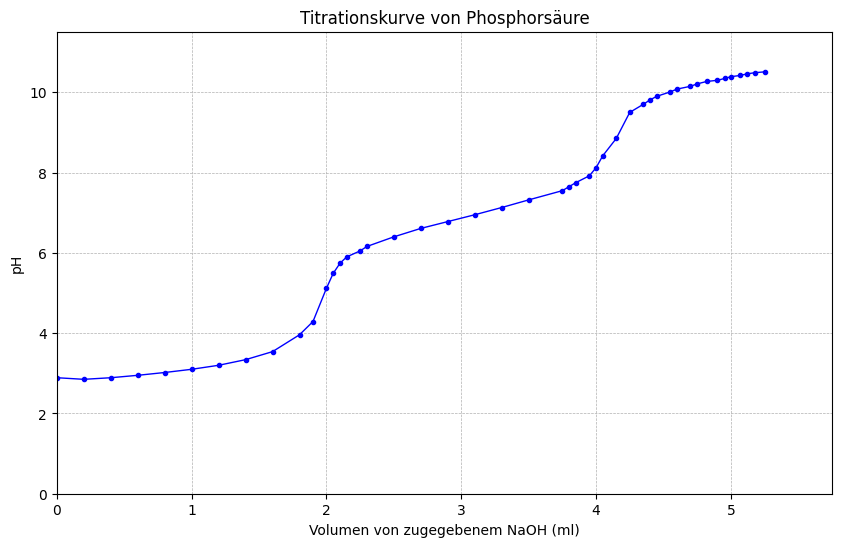

In [3]:
# Erstellen einer Titrationskurve
titration_analysis.set1.plot_curve()


In [4]:
#Tangenten für verschiedene Punkte
titration_analysis.set1.add_tangent([1.2, 3.20], 'orange', length=2.0)
titration_analysis.set1.add_tangent([1.9, 4.29], 'orange', length=2.0)
titration_analysis.set1.add_tangent([2.5, 6.40], 'orange', length=2.0)

titration_analysis.set2.add_tangent([3.1, 6.95], 'green', length=2.0)
titration_analysis.set2.add_tangent([4.15, 8.85], 'green', length=2.0)
titration_analysis.set2.add_tangent([4.70, 10.15], 'green', length=2.0)


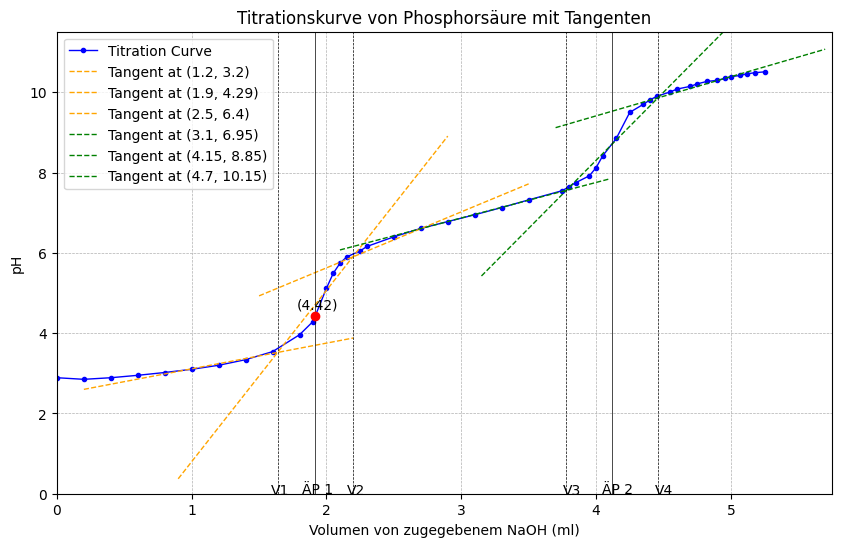

In [5]:
# Darstellung der Titrationskurve mit Tangenten und Schnittpunkten
titration_analysis.plot_with_tangents()

In [6]:
intersections_1 = titration_analysis.set1.find_intersections()
for key, intersect in intersections_1.items():
    print(f'Set 1 Intersection {key} at Volume = {intersect[0]:.2f} ml, pH = {intersect[1]:.2f}')

intersections_2 = titration_analysis.set2.find_intersections()
for key, intersect in intersections_2.items():
    print(f'Set 2 Intersection {key} at Volume = {intersect[0]:.2f} ml, pH = {intersect[1]:.2f}')


Set 1 Intersection (1.2, 3.2)_vs_(1.9, 4.29) at Volume = 1.64 ml, pH = 3.52
Set 1 Intersection (1.9, 4.29)_vs_(2.5, 6.4) at Volume = 2.19 ml, pH = 5.90
Set 2 Intersection (3.1, 6.95)_vs_(4.15, 8.85) at Volume = 3.78 ml, pH = 7.56
Set 2 Intersection (4.15, 8.85)_vs_(4.7, 10.15) at Volume = 4.46 ml, pH = 9.86


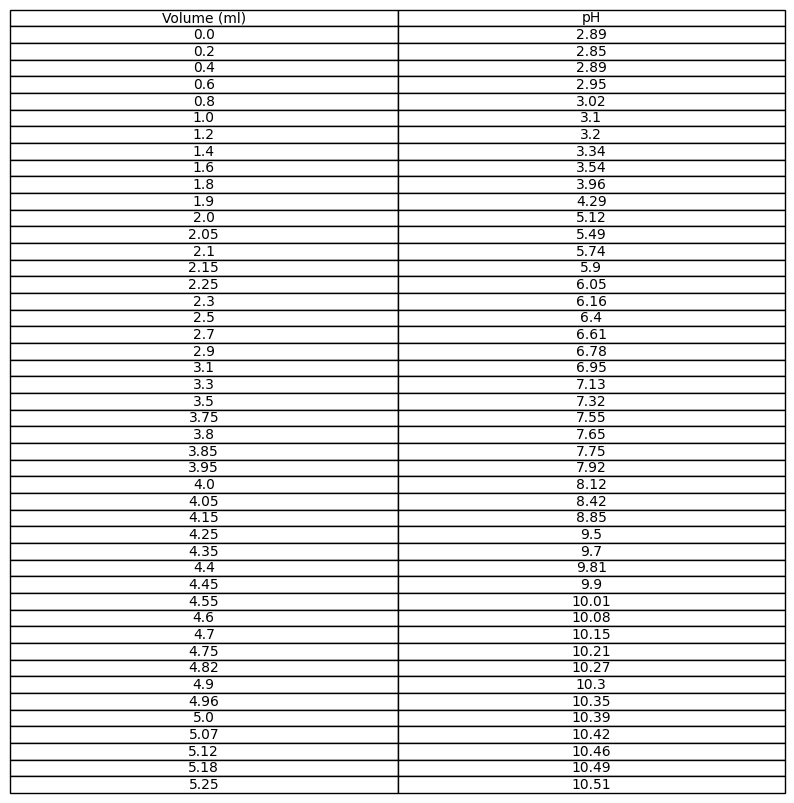

In [7]:
titration_analysis.set1.display_table()

In [8]:
titration_analysis.set1.save_data()